In [1]:
import numpy as np
import scipy

import xarray as xr
import cmocean as cmo
from numpy import linalg as LA

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from glob2 import glob

from tqdm import tqdm
from swath_rossby_wave import skill_matrix, build_h_matrix2, build_hswath_matrix2
from swath_rossby_wave import inversion, make_error_over_time


In [2]:
# set standard deviation of error parameters
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3)

In [3]:
# identify the alpha_std value to use for this case study
iuse_alpha=12
# set start dates for months
day0_array = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
# choose month to use for this case study
month_number=0
day_start=day0_array[month_number]

In [4]:
day0, day1 = 0, 40 # 
Tdim = day1 - day0
n_waves = '190' #number of waves
time_range = 2 * (day1 - day0) # assimilation + forecast window

MModes = 1 # Rossby wave vertical modes
wave_files = glob('./rossby_wave_estimate_*_' + n_waves + 'waves_swotdomain_40days.nc')
wave_files = sorted(wave_files)

lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
# read in AVISO/Copernicus SSHA data and use to set mask
SSHA = aviso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
# remove mean from AVISO field
SSHA = SSHA-SSHA[:].mean(axis = -1)
# set land mask
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked[:,:,day0:(day1-day0)*2])
lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data
T_time = aviso_ds.time.data[day0:] * 86400 # in seconds
date_time = aviso_ds.date_time.data[day0+day_start:]

# set parameters for Rossby wave propagationn model
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 # 45 N

# hard wired parameters
# values of R matrix (on diagonal)
# R = 0.001 # noise = 3.1 cm
R = 0.01 # noise = 10. cm  ##default
# R = 0.1 # noise = 31. cm

# scaling factor for correlated error
# sigma_scale = 0.65 # scale so that RMS correlated error matches applied sigma (empirically derived)
sigma_scale = 1.00 # default
# sigma_scale = 0.3 # effective sigma smaller than RMS correlated error

## use default values for cast study figures

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
# list SWOT data files
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))

In [6]:
# identify SWOT tracks---here using only 2 sample tracks from one-day repeat orbit
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))
swot_ds = xr.open_mfdataset(swot_files, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})


In [7]:
# Read swot_ds to identify SWOT data coordinates

# Extract the nadir position for the ground track
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values-360

# Extract the latitudes and longitudes within the swath
latitude = swot_ds['latitude'].values
longitude = swot_ds['longitude'].values-360

# read cross track distance, and depth
cross_track = swot_ds['cross_track_distance'].values
depth=swot_ds['depth_or_elevation'].values

# use a brute-strength approach to separate ascending and descending tracks
direction = np.sign(np.diff(latitude,n=1,axis=0))

# to tightly distinguish ascending and descening, use time difference between reference tracks
time_swot = swot_ds['time'].values
time_hrs=time_swot[:].astype('datetime64[h]').astype(int)-466680
direction_asc = np.all([time_hrs >5,time_hrs < 11],axis=0)
direction_des = np.all([time_hrs >=11,time_hrs < 22],axis=0)

In [8]:
# prepare a mask for in-swath vs out-of-swath data
mask_asc=np.zeros([len(lat),len(lon)])
mask_des=np.zeros([len(lat),len(lon)])
mask_total=np.zeros([len(lat),len(lon)])

y1=latitude[:,2]
x1=longitude[:,2]
y2=latitude[:,66]
x2=longitude[:,66]
index_asc=np.where(direction_asc[:])
lon_edge1=np.interp(lat,y1[index_asc],x1[index_asc])
lon_edge2=np.interp(lat,y2[index_asc],x2[index_asc])
index_des=np.where(direction_des[:])
lon_edge3=np.interp(lat,np.flip(y1[index_des]),np.flip(x1[index_des]))
lon_edge4=np.interp(lat,np.flip(y2[index_des]),np.flip(x2[index_des]))
for i in range(len(lat)):
    for j in range(len(lon)):
        if(lon[j]>=lon_edge1[i] and lon[j]<=lon_edge2[i]):
            mask_asc[i,j]=1
        if(lon[j]<=lon_edge3[i] and lon[j]>=lon_edge4[i]):  # descending order reversed
            mask_des[i,j]=1.  
        if(mask_asc[i,j]==1 or mask_des[i,j]==1):
            mask_total[i,j]=1 

In [9]:
# Arrays to store variance explained
# case study.  set dimensions to 1.
nsigma=1  ###  for full analysis, use len(alpha_std)
nfiles=1  ###  for full analysis, use len(wave_files)
variance_explained_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_2step = np.zeros([nfiles, nsigma, time_range])

In [10]:
# define stratification for Rossby wave model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data

# set longitude and latitude anomalies relative to mean
dlon = lon - lon.mean()
dlat = lat - lat.mean()
 
# pre-fill output arrays with zeros
rms_err, rms_ssh = np.zeros([nfiles, nsigma]), np.zeros([nfiles, nsigma])
rms_err2, rms_ssh2 = np.zeros([nfiles, nsigma]), np.zeros([nfiles, nsigma])

ssh_est_skill2, err_est_skill2 = np.zeros([nfiles, nsigma]), np.zeros([nfiles, nsigma])

ssh_est_skill1, err_est_skill1 = np.zeros([nfiles, nsigma]), np.zeros([nfiles, nsigma])

total_est_skill1, total_est_skill2 = np.zeros([nfiles, nsigma]), np.zeros([nfiles, nsigma])


In [11]:
# read in first file and configure basic matrix information
n=0
ndays=day1-day0

wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)

Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

MSLA0 = MSLA_fwd[:, :, day0:day1]

### assess skill, get indices
# note that this measure of skill is not used subsequently
# code was written this way to test fraction of variance explained by each wavenumber combination
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

M = k_n.size * l_n.size # Number of models/waves

# define matrix inversion, accounting for land gaps
# matrix H_all is consistent for all start dates
H_all, SSHA_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)

# create a dummy masked matrix in order to build the full H matrix
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

# create full matrices, no land gaps, to faciliate projection
# matrices are consistent for all start dates
H_all_full_grid, SSHA_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)
H_all_full_grid2, SSH_vector2_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, ndays)

In [12]:
ssh_reconstructed=np.matmul(H_all_full_grid, amp)

In [13]:
# identify points to use within swath and remove swath points that won't be used
mask=np.zeros([latitude.shape[0],latitude.shape[1]])
deltax=np.zeros([latitude.shape[0],latitude.shape[1]])
asc_des=np.zeros([latitude.shape[0],latitude.shape[1]])

# chose cross-track positions
#  original code used range(2,latitude.shape[1],8), but here the indices are hard-wired in order to skip the
# gap at nadir
# use=range(2,len(counter),8)
use2=[2, 10, 18, 26,42,50,58,66]

deltax=cross_track/1.e5 # distance in 100 km, relative to nadir
asc_des=(direction+1)/2.  ## 1 = ascending; 0 = descending
for i in range(0,latitude.shape[0]-1,16):
    for j in use2:
        if(latitude[i,j]>=min(lat) and latitude[i,j]<=max(lat) and depth[i,j]<=0 
           and longitude[i,j]<=max(lon) and longitude[i,j]>=min(lon)):
            mask[i,j]=1

index=np.where(mask==1)

In [14]:
# define an H matrix for swath points only
H_swath = build_hswath_matrix2(ssha_clean, MModes, k_n, l_n, lon,lat,longitude, latitude, index, T_time, Psi, Rm, day0-day0)

In [15]:
# set indices for roll error, by counting backwards
IND_TIMING = -7 
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [16]:
Valid_points = len(index[0]) 
err_basis_func = np.zeros([Valid_points, 2, 7])
H_swath_roll = np.zeros([Tdim*Valid_points,Tdim*14])

tt=0
for ii in range(len(index[0])):
    iuse=index[0][ii]
    juse=index[1][ii]
    iasc=int(asc_des[iuse,juse])
    #timing error
    err_basis_func[ii, iasc, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, iasc, IND_ROLL] = deltax[iuse,juse]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, iasc, IND_BASELINE] = deltax[iuse,juse]**2  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * deltax[iuse,juse], 1) #
    H_pos = np.heaviside(deltax[iuse,juse], 1) # 
    err_basis_func[ii, iasc, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE4] = deltax[iuse,juse] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, iasc, IND_PHASE6] = deltax[iuse,juse] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
 
err_basis_func=err_basis_func.reshape([Valid_points, 14])
    
for tt in range(Tdim):
    # print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
    H_swath_roll[tt*Valid_points:(tt+1)*Valid_points, tt * 14 : (tt+1) * 14] = err_basis_func

In [17]:
# build total H matrix for in-swath data by concatenating Rossby wave and correlated error matrices
H_swath_total = np.concatenate((H_swath, H_swath_roll),axis=1)

In [18]:
# diagnostic:  reconstruct "true" data on swath

map_swath=np.matmul(H_swath,amp)

In [19]:
# set time duration 
Tdim=day1-day0

In [20]:
#  build covariance matrix:  R over P

counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0 

M = l_n.size * k_n.size
p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0

for kk in k_n:
    for ll in l_n:
        k_[counter] = kk 
        l_[counter]  = ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

In [21]:
# redo R_over_P adding in covariance for roll error; this will change with each assumed roll error uncertainty
sigma=alpha_std[iuse_alpha]  ## temporary value to set up matrix
p_diagonal = np.diagonal(R_over_P)
p_diagonal_roll = np.zeros([Tdim * 7*2])
p_diagonal_roll[:] = R/sigma ** 2 
R_over_P_total = np.zeros([len(p_diagonal)+len(p_diagonal_roll),len(p_diagonal)+len(p_diagonal_roll)])

np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)))

In [22]:
sigma

0.0125

In [23]:
# Two-stage approach: reconstructing the SSH separately from solving the correlated error

# First step: fit errors
H_v1 = H_swath_total[:, -7 *2* Tdim:]
R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
HTH = np.matmul(H_v1.T, H_v1)
HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
D1 = np.matmul(LA.inv(HRH), H_v1.T)

In [24]:
# second step: fit residual to rossby wave models

H_v = H_swath_total[:, :-7 *2* Tdim]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P_total[:-7 *2* Tdim, :-7 *2* Tdim]  # !!!  move into loop
D2 = np.matmul(LA.inv(HRH), H_v.T)

In [25]:
# here's where we would loop through all files
# but this is a case study, so we skip the loop and run only one start date and one sigma
with tqdm(total= rms_err[:,0].size) as pbar:
#    fake loop to capture one case study only  (full range would use:  for n in range(len(wave_files)):
    for n in range(1): ## first file only, date n
        wave_ds = xr.open_dataset(wave_files[month_number]) # forward model - filtered AVISO
        MSLA_fwd = wave_ds.MSLA_forward.data
        MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)
        temp=MSLA_fwd[:,:,:40].transpose([2,0,1])
        MSLA_vector=np.ma.compressed(temp.flatten())

        amp_recovered, ssh_estimated = inversion(MSLA_vector, H_all, R_over_P)
        
        # map "true" data on swath
        amp = wave_ds.Amplitudes.data
        ssh=np.matmul(H_swath,amp)
        N=len(ssh)
    
        # Loop over sigma
        sigma_counter = 0
        
        for sigma in alpha_std[iuse_alpha:iuse_alpha+1]: # std of error amp  ### choose a single value to generate plots

            # Add errors to the swaths
            mu = 0
            time_factor = np.arange(1, 1 + day1-day0)
            # generate error parameter with Gaussian distribution
            np.random.seed(n*len(alpha_std)+sigma_counter)# optional:  use random number seed to support reproducibility
            alpha=np.random.normal(mu,sigma,[Tdim,7,2]) # set up an array of Gaussian random numbers as parameters for roll error

            # produce correlated error
            cor_err  = make_error_over_time(range(day1-day0), alpha, latitude[index], longitude[index], deltax[index], asc_des[index])
            
            input_swath = ssh +cor_err.reshape([len(map_swath)])

            p_diagonal_roll[:] = R/(sigma*sigma_scale) ** 2 # errors---scale to make prior error match inserted variance
            R_over_P_total = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])           
            np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)) )
            
            # 1-stage approach, solve for amplitudes            
            amp_1step, ssh_estimated_swath = inversion(input_swath, H_swath_total, R_over_P_total)
            
            # 1-stage approach, find values at swath points
            swath_one_stage = np.matmul(H_swath, amp_1step[:H_all_full_grid.shape[1]])
            err_swath_one_stage = np.matmul(H_swath_roll, amp_1step[H_all_full_grid.shape[1]:])
            
            # now use 1-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_1step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)

            # within the swath, estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_swath_total[:, -7*2*Tdim:], amp_1step[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_swath_total[:, :-7*2*Tdim], amp_1step[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err.reshape([len(map_swath)])
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.var(ssh))
            err_diff1  = (np.mean(err_diff**2)) / (np.var(cor_err))
            total_diff1 = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Two-stage approach: reconstructing the SSH separately from solving the correlated error
            #  First step: fit errors; R over P matrix varies in time, so need to recompute
            H_v1 = H_swath_total[:, -7 *2* Tdim:]
            R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, input_swath)

            # correlated errors have different R over P with time,, so recompute
            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

            # second step: fit residual to rossby wave models
            # matrix does not vary, so skip recomputing
            tau_ssh = input_swath - err_est_2step
            amp_swath_2step = np.matmul(D2, tau_ssh)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

            # Important result: 2-stage error estimate skill and ssh estimate skill relative to swath data
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err.reshape([len(map_swath)])
            # ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.mean(ssh ** 2))
            # err_diff_2stage = (np.mean(err_diff ** 2)) / (np.mean(cor_err ** 2))
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.var(ssh))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.var(cor_err))
            total_diff_2stage = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))
            rms_err2[n, sigma_counter] = np.std(cor_err)
            rms_ssh2[n, sigma_counter]= np.std(ssh)

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,
            total_est_skill2[n, sigma_counter] = (1 - total_diff_2stage.mean()) * 100
            
            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,
            total_est_skill1[n, sigma_counter] = (1 - total_diff1.mean()) * 100
            
            # now use 2-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_swath_2step)
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_swath_2step)
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_2step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)
            
            for i in range(time_range):
                # Masking the in-track and out-of-track data
                msla_in = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwd[:, :, i])
                msla_out = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwd[:, :, i])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_out_1step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_in_2step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_2step[:, :, i])
                msla_fwrd_out_2step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_2step[:, :, i])

                # Variance of original data for in-swath and out-of-swath
                original_var_in = np.var(msla_in)
                original_var_out = np.var(msla_out)

                # Variance of predictions for in-swath and out-of-swath (1-step)
                predicted_var_in_1step = np.var(msla_fwrd_in_1step)
                predicted_var_out_1step = np.var(msla_fwrd_out_1step)

                # Variance of predictions for in-swath and out-of-swath (2-step)
                predicted_var_in_2step = np.var(msla_fwrd_in_2step)
                predicted_var_out_2step = np.var(msla_fwrd_out_2step)

                # Variance explained (1-step)
                variance_explained_1step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_1step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_1step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
                variance_explained_out_1step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)

                # Variance explained (2-step)
                variance_explained_2step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_2step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_2step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
                variance_explained_out_2step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)
                        
                    
            sigma_counter += 1

        pbar.update(1)

100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


In [26]:
total_diff_2stage = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
total_diff1 = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
(1 - total_diff1.mean()) * 100, (1 - total_diff_2stage.mean()) * 100

(99.32444243806037, 99.32444243806037)

In [27]:
# in swath skill
print('variance explained in swath, 1 stage:',ssh_est_skill1[0,0])
print('variance explained in swath, 2 stage:',ssh_est_skill2[0,0])
print('error variance explained in swath, 1 stage:',err_est_skill1[0,0])
print('error variance explained in swath, 2 stage:',err_est_skill2[0,0])
print('total variance explained in swath, 1 stage:',total_est_skill1[0,0])
print('total variance explained in swath, 2 stage:',total_est_skill2[0,0])

variance explained in swath, 1 stage: 99.85848735828077
variance explained in swath, 2 stage: 66.16445255886751
error variance explained in swath, 1 stage: 93.50987679172012
error variance explained in swath, 2 stage: -200.3152898535717
total variance explained in swath, 1 stage: 99.45228230779124
total variance explained in swath, 2 stage: 99.32444243806037


In [28]:
#diagnostics
P_matrix=LA.inv(R_over_P)*R
covariance_matrix=np.matmul(H_swath,np.matmul(P_matrix,H_swath.T))

In [29]:
amp = wave_ds.Amplitudes.data
MSLA_true=np.matmul(H_all_full_grid,amp)
MSLA_true2=np.matmul(H_all_full_grid2,amp)
MSLA_true=np.concatenate((MSLA_true, MSLA_true2),axis=0)
MSLA_true=np.transpose(MSLA_true.reshape(80,MSLA0.shape[0],MSLA0.shape[1]),(1,2,0))

MSLA_recover=np.matmul(H_all_full_grid,amp_recovered)
MSLA_true2=np.matmul(H_all_full_grid2,amp_recovered)
MSLA_recover=np.concatenate((MSLA_recover, MSLA_true2),axis=0)
MSLA_recover=np.transpose(MSLA_recover.reshape(80,MSLA0.shape[0],MSLA0.shape[1]),(1,2,0))

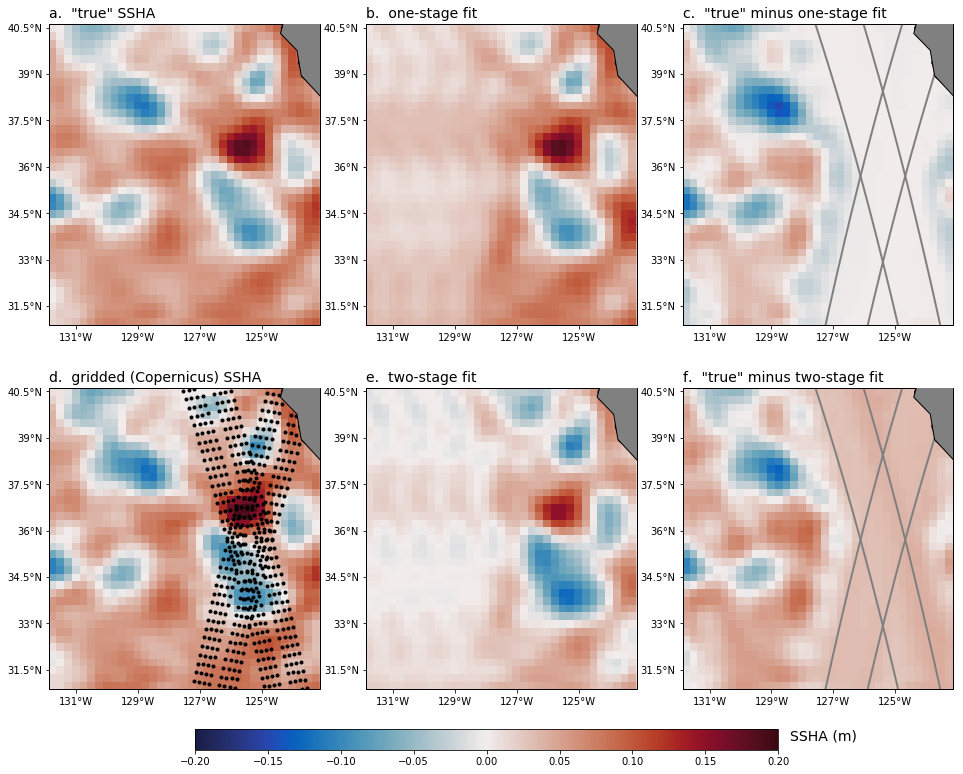

In [30]:
## Figure 6:  True MSLA, fitted MSLA, 1-stage, 2-stage

fig, ax = plt.subplots(2,3,figsize=(13.5, 11.5),subplot_kw={'projection': ccrs.PlateCarree()})
i=20

ax[0,0].pcolormesh(lon, lat, MSLA_fwd[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2) 
ax[0,0].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[0,0].coastlines(resolution='50m')
ax[0,0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0,0].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[0,0].set_title('a.  "true" SSHA', fontsize=14,loc='left')
ax[0,0].set_xticks(np.arange(-131,-123,2))
ax[0,0].set_yticks(np.arange(31.5,42,1.5))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0,0].xaxis.set_major_formatter(lon_formatter)
ax[0,0].yaxis.set_major_formatter(lat_formatter)

ax[0,1].pcolormesh(lon, lat, MSLA_fwrd_1step[:,:,i], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
ax[0,1].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[0,1].coastlines(resolution='50m')
ax[0,1].add_feature(cfeature.BORDERS, linestyle=':')
ax[0,1].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[0,1].set_title('b.  one-stage fit', fontsize=14,loc='left')
ax[0,1].set_xticks(np.arange(-131,-123,2))
ax[0,1].set_yticks(np.arange(31.5,42,1.5))
ax[0,1].xaxis.set_major_formatter(lon_formatter)
ax[0,1].yaxis.set_major_formatter(lat_formatter)

ax[0,2].pcolormesh(lon, lat, MSLA_fwd[:,:,i]-MSLA_fwrd_1step[:,:,i], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
ax[0,2].plot(longitude[:,2],latitude[:,2],color='gray',linewidth=2)
ax[0,2].plot(longitude[:,66],latitude[:,66],color='gray',linewidth=2)
ax[0,2].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[0,2].coastlines(resolution='50m')
ax[0,2].add_feature(cfeature.BORDERS, linestyle=':')
ax[0,2].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[0,2].set_title('c.  "true" minus one-stage fit', fontsize=14,loc='left')
ax[0,2].set_xticks(np.arange(-131,-123,2))
ax[0,2].set_yticks(np.arange(31.5,42,1.5))
ax[0,2].xaxis.set_major_formatter(lon_formatter)
ax[0,2].yaxis.set_major_formatter(lat_formatter)


cs=ax[1,0].pcolormesh(lon, lat, SSHA_masked[:,:,i+day0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
ax[1,0].plot(longitude[index], latitude[index], 'k.')
ax[1,0].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[1,0].coastlines(resolution='50m')
ax[1,0].add_feature(cfeature.BORDERS, linestyle=':')
ax[1,0].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[1,0].set_xticks(np.arange(-131,-123,2))
ax[1,0].set_yticks(np.arange(31.5,42,1.5))
ax[1,0].xaxis.set_major_formatter(lon_formatter)
ax[1,0].yaxis.set_major_formatter(lat_formatter)
ax[1,0].set_title('d.  gridded (Copernicus) SSHA', fontsize=14,loc='left')

ax[1,1].pcolormesh(lon, lat, MSLA_fwrd_2step[:,:,i], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
ax[1,1].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[1,1].coastlines(resolution='50m')
ax[1,1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1,1].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[1,1].set_title('e.  two-stage fit', fontsize=14,loc='left')
ax[1,1].set_xticks(np.arange(-131,-123,2))
ax[1,1].set_yticks(np.arange(31.5,42,1.5))
ax[1,1].xaxis.set_major_formatter(lon_formatter)
ax[1,1].yaxis.set_major_formatter(lat_formatter)

ax[1,2].pcolormesh(lon, lat, MSLA_fwd[:,:,i]-MSLA_fwrd_2step[:,:,i], vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
ax[1,2].plot(longitude[:,2],latitude[:,2],color='gray',linewidth=2)
ax[1,2].plot(longitude[:,66],latitude[:,66],color='gray',linewidth=2)
ax[1,2].axis([lon[0],lon[-1],lat[0],lat[-1]])
ax[1,2].coastlines(resolution='50m')
ax[1,2].add_feature(cfeature.BORDERS, linestyle=':')
ax[1,2].add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
ax[1,2].set_title('f.  "true" minus two-stage fit', fontsize=14,loc='left')
ax[1,2].set_xticks(np.arange(-131,-123,2))
ax[1,2].set_yticks(np.arange(31.5,42,1.5))
ax[1,2].xaxis.set_major_formatter(lon_formatter)
ax[1,2].yaxis.set_major_formatter(lat_formatter)

plt.tight_layout()

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=.95, left=0.05, right=0.98,
                    wspace=0.17, hspace=0.07)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.025])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar_ax.text(1.02,0.45,'SSHA (m)',fontsize=14)
plt.savefig('forward_ssh_' + str(sigma)[:6] + '_' + str(date_time[day0+i])[:10] + "_day_" + str(i) + ".pdf")


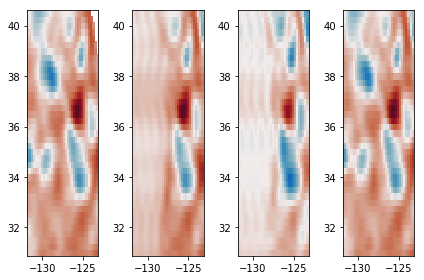

In [31]:
# quick view of different SSH reconstructions
i=20  # day

# "true" SSH
plt.subplot(1,4,1)
plt.pcolormesh(lon,lat,MSLA_fwd[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

# 1-step reconstruction
plt.subplot(1,4,2)
plt.pcolormesh(lon,lat,MSLA_fwrd_1step[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

# 2-step reconstruction
plt.subplot(1,4,3)
plt.pcolormesh(lon,lat,MSLA_fwrd_2step[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

# reconstruction using full domain fit to amplitude
plt.subplot(1,4,4)
plt.pcolormesh(lon,lat,MSLA_recover[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

plt.tight_layout()

In [32]:
def thumbnail_axes(string,lat,lon,ax):
    import numpy as np
    import scipy
    import cmocean as cmo
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.patches as mpatches
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter  
    
    ax.axis([-128,max(lon),min(lat),max(lat)])
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=100, facecolor='gray')
    ax.set_title(string, fontsize=14,loc='left')
    ax.set_xticks(np.arange(-127,-123,3))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)    

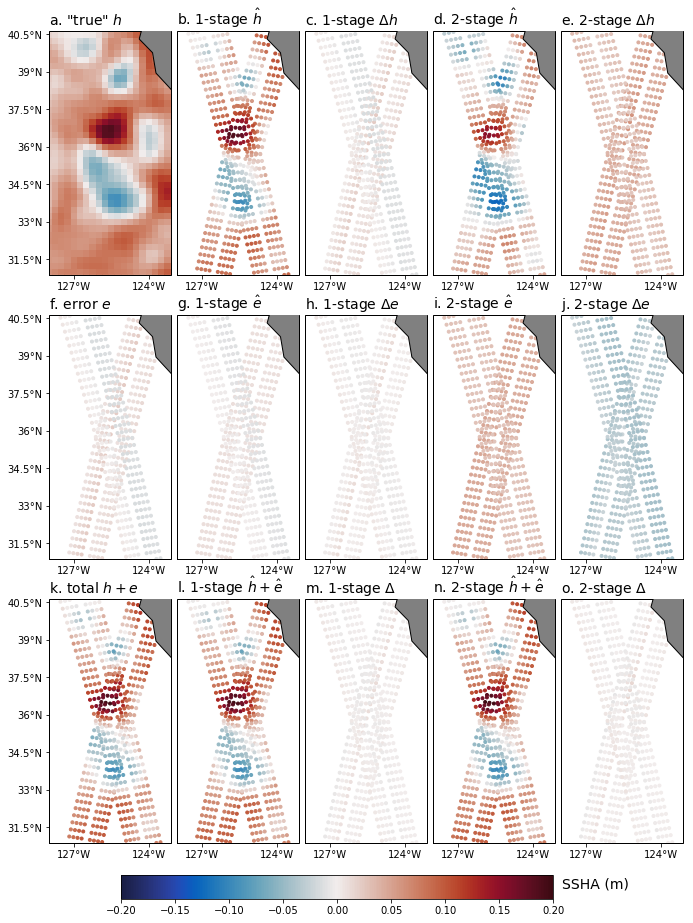

In [39]:
# Figure 5:  scatter plot with along swath misfits
fig, ax = plt.subplots(3,5,figsize=(10, 13.5),subplot_kw={'projection': ccrs.PlateCarree()})
i=20

ssh_swath=ssh.reshape([MSLA0.shape[2],len(index[0])])
cor_err_swath=cor_err.reshape([MSLA0.shape[2],len(index[0])])
total_swath=input_swath.reshape([MSLA0.shape[2],len(index[0])])
ssh_est_1step=ssh_est_1step.reshape([MSLA0.shape[2],len(index[0])])
err_est_1step=err_est_1step.reshape([MSLA0.shape[2],len(index[0])])
ssh_est_2step=ssh_est_2step.reshape([MSLA0.shape[2],len(index[0])])
err_est_2step=err_est_2step.reshape([MSLA0.shape[2],len(index[0])])

im=ax[0,0].pcolormesh(lon, lat, MSLA_fwrd_1step[:,:,i], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
#ax[0,0].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=ssh_swath[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
thumbnail_axes('a. "true" $h$',lat,lon,ax[0,0])
ax[0,0].set_yticks(np.arange(31.5,42,1.5))

ax[0,1].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=ssh_est_1step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[0,1].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('b. 1-stage $\hat{h}$',lat,lon,ax[0,1])

ax[0,2].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=total_swath[i,:]-ssh_est_1step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[0,2].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('c. 1-stage $\Delta h$',lat,lon,ax[0,2])

ax[0,3].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=ssh_est_2step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[0,3].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('d. 2-stage $\hat{h}$',lat,lon,ax[0,3])

ax[0,4].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=total_swath[i,:]-ssh_est_2step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[0,4].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('e. 2-stage $\Delta h$',lat,lon,ax[0,4])

ax[1,0].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err_swath[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,0].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('f. error $e$',lat,lon,ax[1,0])
ax[1,0].set_yticks(np.arange(31.5,42,1.5))

ax[1,1].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=err_est_1step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,1].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('g. 1-stage $\hat{e}$',lat,lon,ax[1,1])

ax[1,2].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err_swath[i,:]-err_est_1step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,2].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('h. 1-stage $\Delta e$',lat,lon,ax[1,2])

ax[1,3].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=err_est_2step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,3].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('i. 2-stage $\hat{e}$',lat,lon,ax[1,3])

ax[1,4].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=cor_err_swath[i,:]-err_est_2step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[1,4].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('j. 2-stage $\Delta e$',lat,lon,ax[1,4])

ax[2,0].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=total_swath[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[2,0].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('k. total ${h+e}$',lat,lon,ax[2,0])
ax[2,0].set_yticks(np.arange(31.5,42,1.5))

ax[2,1].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=ssh_est_1step[i,:]+err_est_1step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[2,1].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('l. 1-stage ${\hat{h}+\hat{e}}$',lat,lon,ax[2,1])

ax[2,2].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=total_swath[i,:]-(ssh_est_1step[i,:]+err_est_1step[i,:]),vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[2,2].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('m. 1-stage $\Delta$',lat,lon,ax[2,2])

ax[2,3].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=ssh_est_2step[i,:]+err_est_2step[i,:],vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[2,3].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('n. 2-stage ${\hat{h}+\hat{e}}$',lat,lon,ax[2,3])

ax[2,4].scatter(longitude[index[0],index[1]],latitude[index[0],index[1]], marker='.',c=total_swath[i,:]-(ssh_est_2step[i,:]+err_est_2step[i,:]),vmin=-0.2, vmax=0.2,cmap=cmo.cm.balance)
ax[2,4].axis([-128,max(lon),min(lat),max(lat)])
thumbnail_axes('o. 2-stage $\Delta$',lat,lon,ax[2,4])

plt.tight_layout()

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.98,
                    wspace=0.05, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.025])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar_ax.text(1.02,0.45,'SSHA (m)',fontsize=14)

plt.savefig('swath_scatter_' + str(sigma)[:6] + '_' + str(date_time[day0+i])[:10] + "_day_" + str(i) + ".pdf")


In [34]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

In [35]:
i=20
print('standard deviation of error relative as a fraction of standard deviation of signal:',rms_err2[0,0]/rms_ssh2[0,0])
print('variance explained in swath, 1 stage:',1-variance_explained_in_1step[0,0,i],np.mean(1-variance_explained_in_1step[0,0,0:40]))
print('variance explained in swath, 2 stage:',1-variance_explained_in_2step[0,0,i],np.mean(1-variance_explained_in_2step[0,0,0:40]))

print('variance explained off swath, 1 stage:',1-variance_explained_out_1step[0,0,i],np.mean(1-variance_explained_out_1step[0,0,0:40]))
print('variance explained off swath, 2 stage:',1-variance_explained_out_2step[0,0,i],np.mean(1-variance_explained_out_2step[0,0,0:40]))

print('variance explained full domain, 1 stage:',1-variance_explained_1step[0,0,i],np.mean(1-variance_explained_1step[0,0,0:40]))
print('variance explained full domain, 2 stage:',1-variance_explained_2step[0,0,i],np.mean(1-variance_explained_2step[0,0,0:40]))

standard deviation of error relative as a fraction of standard deviation of signal: 0.3393192728480934
variance explained in swath, 1 stage: 0.9987968536934736 0.9983302258403736
variance explained in swath, 2 stage: 0.6049143023655936 0.5997999374294116
variance explained off swath, 1 stage: 0.36892956337653715 0.3635314786971993
variance explained off swath, 2 stage: 0.08766503666345349 0.07756086310891383
variance explained full domain, 1 stage: 0.6235918147841606 0.6199172546565299
variance explained full domain, 2 stage: 0.3001209329102844 0.294431795456091


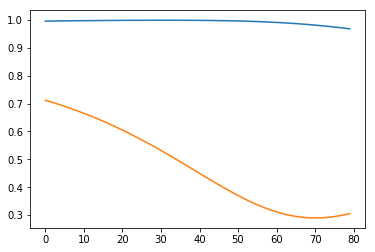

In [36]:
plt.plot(range(80),1-variance_explained_in_1step[0,0,:])
plt.plot(range(80),1-variance_explained_in_2step[0,0,:])

In [37]:
variance_explained_in_1step.shape

(1, 1, 80)

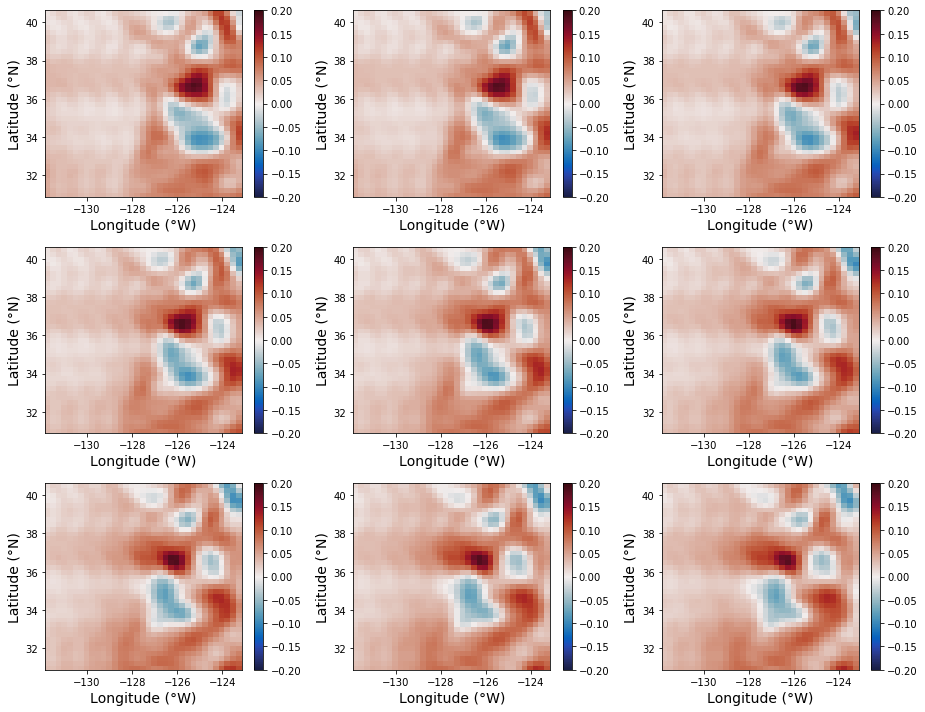

In [38]:
fig = plt.figure(figsize = (13, 10))

icounter=0
for i in [0, 10, 20, 30, 40, 50, 60, 70, 79]:
    icounter=icounter+1
    plt.subplot(3,3,icounter)
    plt.pcolormesh(lon, lat, MSLA_fwrd_1step[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    
plt.tight_layout()